In [ ]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy
import requests
import warnings
import geopandas as gpd

warnings.filterwarnings('ignore')

In [ ]:
# read walkability data into dataframe
df_walk = pd.read_csv('../data/walkability.csv')

In [ ]:
df_walk.head()

In [ ]:
# dataframe that does not consider DC a state
df_walk_no_dc = df_walk[df_walk['State'] != "DC"]

In [ ]:
# group by state, get average walkability score per state and plot 
ax = (
    df_walk_no_dc.groupby('State')['Walk Score'].mean()
    .sort_values(ascending=True)
    .plot
    .barh(figsize=(10, 10), color="mediumpurple")
    # .set_facecolor('darkslategray')
)

ax.vlines(df_walk['Walk Score'].mean(), 0, 1000)

# add 
for i in range(10, len(df_walk['State']), 10):
    ax.axhline(y=i - 0.5, color='cornflowerblue', linestyle='--', linewidth=1)

# plt.xticks(rotation=30)
plt.xlabel("Walkability Score")
plt.ylabel("State Abbreviations")
plt.title("Total Number of Mental Health Facilities per 100,000 People (2016)");

### ANOVA on Walkability Data

In [ ]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
from scipy.stats import f_oneway, shapiro, levene

In [ ]:
# Assuming 'data' is your DataFrame with a column 'WalkabilityScore' and a column 'Group'
data = df_walk_no_dc.groupby('State')['Walk Score'].mean().sort_values(ascending=True).to_frame()

# Shapiro-Wilk test for normality
shapiro_result = shapiro(data['Walk Score'])
shapiro_p_value = shapiro_result.pvalue

# Print result
print(f"Shapiro-Wilk p-value: {shapiro_p_value:.4f}") # value greater than 0.05

In [ ]:
# get top 10 and bottom 10 ranking state and their walkability means
walkability_top10 = df_walk_no_dc.groupby('State')['Walk Score'].mean().sort_values(ascending=True).head(10)
walkability_bottom10 = df_walk_no_dc.groupby('State')['Walk Score'].mean().sort_values(ascending=True).tail(10)

# ANOVA
f_statistic, p_value = f_oneway(walkability_top10, walkability_bottom10)

print(f'F-statistic: {f_statistic:.4f}')
print(f'P-value: {p_value:.4f}')

In [ ]:
# p < 0.05 --> there is significance difference in variance
f, p = levene(walkability_top10, walkability_bottom10)
f, p

## Activity (CDC) data

In [ ]:
df_nutri = pd.read_csv("../data/nutrition_activity.csv")
df_nutri.drop(['Data_Value_Unit', 'Total', 'Data_Value_Type', 'GeoLocation'], axis=1, inplace=True)

In [ ]:
df_nutri.columns

In [ ]:
df_nutri.info()

In [ ]:
df_nutri.head()

Unique question in the dataset: 

|    | ClassID   | QuestionID   | Question                                                                                                                    |
|---:|:----------|:-------------|:----------------------------------------------------------------------------------------------------------------------------|
|  0 | FV        | Q020         | Percent of students in grades 9-12 who consume fruit less than 1 time daily                                                 |
|  1 | FV        | Q021         | Percent of students in grades 9-12 who consume vegetables less than 1 time daily                                            |
|  2 | OWS       | Q038         | Percent of students in grades 9-12 who have obesity                                                                         |
|  3 | OWS       | Q039         | Percent of students in grades 9-12 who have an overweight classification                                                    |
|  4 | PA        | Q048         | Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily |
|  5 | PA        | Q049         | Percent of students in grades 9-12 who participate in daily physical education                                              |
|  6 | SD        | Q058         | Percent of students in grades 9-12 who drank regular soda/pop at least one time per day                                     |
|  7 | TV        | Q059         | Percent of students in grades 9-12 watching 3 or more hours of television each school day                                   |

(table generated with code: 
```python
print(df_nutri.groupby(["ClassID", "QuestionID"])["Question"]
      .unique()
      .reset_index()
      .explode("Question")
      .to_markdown())
```
)

ClassID: 
- FV: Fruit and vegetables
- OWS: Obesity and Weight Status
- PA: Physical activity
- SD: Soda drink consumption
- TV: TV watching behavior

In [ ]:
vegetable_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'FV'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart = lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

In [ ]:
register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = vegetable_trend.plot.line(x='YearStart')
ax.set_title("History trend of students consuming\nvegetables or fruits less than 1 time daily")
xticks = pd.date_range(start=vegetable_trend['YearStart'].min(), end="2020-01-01", freq='2Y')
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime('%Y') for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text('Fruit (Q020)')
L.get_texts()[1].set_text('Vegetables (Q021)')

In [ ]:
obesity_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'OWS'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart = lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = obesity_trend.plot.line(x='YearStart')
ax.set_title("History trend of percent of students who are overweight or obese")
xticks = pd.date_range(start=obesity_trend['YearStart'].min(), end="2020-01-01", freq='2Y')
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime('%Y') for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text('Obesity (Q038)')
L.get_texts()[1].set_text('Overweight (Q039)')

In [ ]:
# soda consumption among overweight and obese students
soda_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'SD'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart = lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = soda_trend.plot.line(x='YearStart')
ax.set_title("History trend of percent of students who are overweight or obese")
xticks = pd.date_range(start=soda_trend['YearStart'].min(), end="2020-01-01", freq='2Y')
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime('%Y') for x in xticks], rotation=45)
plt.xlabel('Year')
plt.ylabel('No. of Students who Drank at least 1 time per Day')
L = plt.legend()
L.get_texts()[0].set_text('Soda (Q058)')

### SNAP Benefits Data
Tables:

1. [Monthly Average Number of Persons Participating in Supplemental Nutrition Assistance Program (SNAP)](https://www.kff.org/other/state-indicator/avg-monthly-participation/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D)
1. [Supplemental Nutrition Assistance Program (SNAP) Total Benefits](https://www.kff.org/other/state-indicator/total-snap-program-benefits/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D)
1. [Average Supplemental Nutrition Assistance Program (SNAP) Benefits Per Person](https://www.kff.org/other/state-indicator/avg-monthly-snap-benefits/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D)


In [ ]:
# URL of the website
url1 = "https://www.kff.org/other/state-indicator/avg-monthly-participation/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D"
url2 = "https://www.kff.org/other/state-indicator/total-snap-program-benefits/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D"
url3 = "https://www.kff.org/other/state-indicator/avg-monthly-snap-benefits/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D"


In [ ]:
# read in the tables
# month_avg = pd.read_html(url1)
# total_benefits = pd.read_html(url2)
# avg_benefits = pd.read_html(url3)

In [ ]:
month_avg = pd.read_csv("month_avg.csv", skiprows=[0,1,3], nrows=53)
total_benefits = pd.read_csv("total_benefits.csv", skiprows=[0,1])
avg_benefits = pd.read_csv("avg_benefits.csv", skiprows=[0,1])

In [ ]:
month_avg.head()

In [ ]:
month_avg.sort_values("Average Monthly SNAP Participants").plot.barh(
    x="Location",
    y="Average Monthly SNAP Participants",
    figsize=(10, 10),
)
plt.xlabel("Number of Average Monthly SNAP Participants (Millions)")
plt.ylabel("State");

In [2]:
# read walkability data into dataframe
df_walk = pd.read_csv('../data/walkability.csv')

In [4]:
# dataframe that does not consider DC a state
df_walk_no_dc = df_walk[df_walk['State'] != "DC"]

### ANOVA on Walkability Data

In [7]:
# Assuming 'data' is your DataFrame with a column 'WalkabilityScore' and a column 'Group'
data = df_walk_no_dc.groupby('State')['Walk Score'].mean().sort_values(ascending=True).to_frame()

# Shapiro-Wilk test for normality
shapiro_result = shapiro(data['Walk Score'])
shapiro_p_value = shapiro_result.pvalue

# Print result
print(f"Shapiro-Wilk p-value: {shapiro_p_value:.4f}") # value greater than 0.05

Shapiro-Wilk p-value: 0.0756


In [10]:
# p < 0.05 --> there is significance difference in variance
f, p = levene(walkability_top10, walkability_bottom10)
f, p

(6.860200965974282, 0.01738267304823813)

## Activity (CDC) data

In [12]:
df_nutri.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Datasource',
       'Class', 'Topic', 'Question', 'Data_Value', 'Data_Value_Alt',
       'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
       'Low_Confidence_Limit', 'High_Confidence_Limit ', 'Sample_Size',
       'Gender', 'Grade', 'Race/Ethnicity', 'ClassID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'LocationID', 'StratificationCategory1',
       'Stratification1', 'StratificationCategoryId1', 'StratificationID1'],
      dtype='object')

In [14]:
df_nutri.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value,Data_Value_Alt,...,Race/Ethnicity,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2019,2019,AK,Alaska,Youth Risk Behavior Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,9.6,9.6,...,Asian,PA,PA1,Q048,VALUE,2,Race/Ethnicity,Asian,RACE,RACEASN
1,2019,2019,AZ,Arizona,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,13.3,13.3,...,NaN,OWS,OWS1,Q038,VALUE,4,Total,Total,OVR,OVERALL
2,2019,2019,DC,District of Columbia,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,17.1,17.1,...,NaN,OWS,OWS1,Q038,VALUE,11,Total,Total,OVR,OVERALL
3,2019,2019,IL,Illinois,Youth Risk Behavior Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who partici...,65.9,65.9,...,NaN,PA,PA1,Q049,VALUE,17,Grade,10th,GRADE,GRADE10
4,2019,2019,MD,Maryland,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have an...,16.7,16.7,...,2 or more races,OWS,OWS1,Q039,VALUE,24,Race/Ethnicity,2 or more races,RACE,RACE2PLUS


In [15]:
vegetable_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'FV'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart = lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

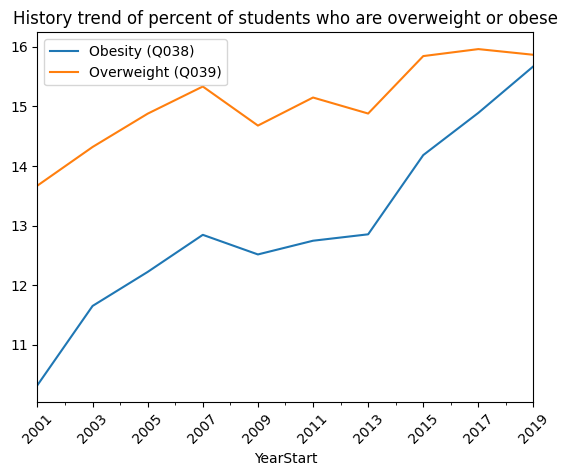

In [17]:
obesity_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'OWS'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart = lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = obesity_trend.plot.line(x='YearStart')
ax.set_title("History trend of percent of students who are overweight or obese")
xticks = pd.date_range(start=obesity_trend['YearStart'].min(), end="2020-01-01", freq='2Y')
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime('%Y') for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text('Obesity (Q038)')
L.get_texts()[1].set_text('Overweight (Q039)')

### SNAP Benefits Data
Tables:

1. [Monthly Average Number of Persons Participating in Supplemental Nutrition Assistance Program (SNAP)](https://www.kff.org/other/state-indicator/avg-monthly-participation/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D)
1. [Supplemental Nutrition Assistance Program (SNAP) Total Benefits](https://www.kff.org/other/state-indicator/total-snap-program-benefits/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D)
1. [Average Supplemental Nutrition Assistance Program (SNAP) Benefits Per Person](https://www.kff.org/other/state-indicator/avg-monthly-snap-benefits/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D)


In [21]:
# read in the tables
# month_avg = pd.read_html(url1)
# total_benefits = pd.read_html(url2)
# avg_benefits = pd.read_html(url3)

In [46]:
month_avg.head()

,Location,Average Monthly SNAP Participants,Footnotes
0,California,4627744.0,NaN
1,Texas,3440726.0,NaN
2,Florida,2847086.0,NaN
3,New York,2839326.0,NaN
4,Illinois,1981714.0,NaN
